In [48]:
#import code from previous parts
from pathlib import Path
from warnings import simplefilter
import requests as r
import json
import time
import datetime
import matplotlib.pyplot as plt
import pandas as pd
from pandas.io.json import json_normalize
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from xgboost import XGBRegressor
from pytrends.request import TrendReq
pytrend = TrendReq(hl='en-US', tz=360)


simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)

In [49]:
# Get a list of all the card information. I chose card name, card ID, and the set:
CardList = [['Giratina VSTAR (Secret) - Crown Zenith: Galarian Gallery (CRZ:GG)',478100,'Crown Zenith'],
            ['Arceus VSTAR (Secret) - Crown Zenith: Galarian Gallery (CRZ:GG)',478101,'Crown Zenith'],
            ['Mewtwo VSTAR - Crown Zenith: Galarian Gallery (CRZ:GG)',477057,'Crown Zenith'],
            ['Origin Forme Dialga VSTAR (Secret) - Crown Zenith: Galarian Gallery (CRZ:GG)',478099,'Crown Zenith'],
            ['Origin Forme Palkia VSTAR (Secret) - Crown Zenith: Galarian Gallery (CRZ:GG)',478097,'Crown Zenith'],
            ['Leafeon VSTAR - Crown Zenith: Galarian Gallery (CRZ:GG)',477060,'Crown Zenith'],
            ['Glaceon VSTAR - Crown Zenith: Galarian Gallery (CRZ:GG)',477061,'Crown Zenith'],
            ['Suicune V - Crown Zenith: Galarian Gallery (CRZ:GG)',478067,'Crown Zenith'],
            ['Elesas Sparkle (Full Art) - Crown Zenith (CRZ)',477241,'Crown Zenith'],
            ['Pikachu (Secret) - Crown Zenith (CRZ)',478103,'Crown Zenith'],
            ['Lugia V (Alternate Full Art) - SWSH12: Silver Tempest (SWSH12)',451834,'Silver Tempest'],
            ['Rayquaza VMAX - SWSH12: Silver Tempest Trainer Gallery (SWSH12: TG)',452034,'Silver Tempest'],
            ['Unown V (Alternate Full Art) - SWSH12: Silver Tempest (SWSH12)',451825,'Silver Tempest'],
            ['Serena (Full Art) - SWSH12: Silver Tempest (SWSH12)',451841,'Silver Tempest'],
            ['Lugia VSTAR (Secret) (202) - SWSH12: Silver Tempest (SWSH12)',451995,'Silver Tempest'],
            ['Regidrago V (Alternate Full Art) - SWSH12: Silver Tempest (SWSH12)',451832,'Silver Tempest'],
            ['Lugia VSTAR (Secret) (211) - SWSH12: Silver Tempest (SWSH12)',452009,'Silver Tempest'],
            ['Alolan Vulpix VSTAR (Secret) - SWSH12: Silver Tempest (SWSH12)',451987,'Silver Tempest'],
            ['Skuntank V (Alternate Full Art) - SWSH12: Silver Tempest (SWSH12)',451829,'Silver Tempest'],
            ['Friends in Galar - SWSH12: Silver Tempest Trainer Gallery (SWSH12: TG)',452039,'Silver Tempest'],
            ['iratina V (Alternate Full Art) - SWSH11: Lost Origin (SWSH11)',284137,'Lost Origin'],
            ['Aerodactyl V (Alternate Full Art) - SWSH11: Lost Origin (SWSH11)',284122,'Lost Origin'],
            ['Pikachu VMAX - SWSH11: Lost Origin Trainer Gallery (SWSH11: TG)',284283,'Lost Origin'],
            ['Rotom V (Alternate Full Art) - SWSH11: Lost Origin (SWSH11)',284119,'Lost Origin'],
            ['Galarian Perrserker V (Alternate Full Art) - SWSH11: Lost Origin (SWSH11)',284135,'Lost Origin'],
            ['Pikachu V - SWSH11: Lost Origin Trainer Gallery (SWSH11: TG)',284278,'Lost Origin'],
            ['Giratina VSTAR (201) (Secret) - SWSH11: Lost Origin (SWSH11)',284156,'Lost Origin'],
            ['Giratina VSTAR (212) (Secret) - SWSH11: Lost Origin (SWSH11)',284167,'Lost Origin'],
            ['Eternatus VMAX - SWSH11: Lost Origin Trainer Gallery (SWSH11: TG)',284295,'Lost Origin'],
            ['Aerodactyl VSTAR (Secret) - SWSH11: Lost Origin (SWSH11)',284154,'Lost Origin']]

In [50]:
CRZ_startdate = '01/20/2023'  #Crown Zenith
SIT_startdate = '11/11/2022'  #Silver Tempest
LOR_startdate = '09/09/2022'  #Lost Origin

CRZ_enddate = ''
SIT_enddate = ''
LOR_enddate = ''

#CRZ was released less than 90 days than when this was written
#Added this in so I wouldnt have to rewrite it on a later date
#Get current date and compare to Crown Zenith release date; Grab up to 90 days if available

date_1 = datetime.datetime.strptime(CRZ_startdate, "%m/%d/%Y")
end_date = date_1 + datetime.timedelta(days=90)

current_date = datetime.datetime.today()

if end_date >= current_date:
    CRZ_enddate = str(current_date.date())
else:
    CRZ_enddate = str(end_date.date())
    
#Reformat dates to find 90 days after sets released
    
CRZ_startdate = datetime.datetime.strptime(CRZ_startdate, "%m/%d/%Y").date()
SIT_startdate = datetime.datetime.strptime(SIT_startdate, "%m/%d/%Y").date()
LOR_startdate = datetime.datetime.strptime(LOR_startdate, "%m/%d/%Y").date()

SIT_enddate = SIT_startdate + datetime.timedelta(days=90)
LOR_enddate = LOR_startdate + datetime.timedelta(days=90)

#Reformat dates to strings. Used later when requesting data from Google Trends

CRZ_startdate = str(CRZ_startdate)
SIT_startdate = str(SIT_startdate)
LOR_startdate = str(LOR_startdate)

SIT_enddate = str(SIT_enddate)
LOR_enddate = str(LOR_enddate)

In [51]:
#Check to see everything was formatted correctly and is working
print('Crown Zenith is from '+ CRZ_startdate + ' to ' + CRZ_enddate + '.')
print('Silver Tempest is from '+ SIT_startdate + ' to ' + SIT_enddate + '.')
print('Lost Origin is from '+ LOR_startdate + ' to ' + LOR_enddate + '.')

Crown Zenith is from 2023-01-20 to 2023-02-13.
Silver Tempest is from 2022-11-11 to 2023-02-09.
Lost Origin is from 2022-09-09 to 2022-12-08.


In [47]:
CrownZenithCards = [['Date']]
SilverTempestCards = [['Date']]
LostOriginCards = [['Date']]

i = 0
for i in range(0, len(CardList)):
    if CardList[i][2] == 'Crown Zenith':
        CrownZenithCards[0].append(CardList[i][0])
    elif CardList[i][2] == 'Silver Tempest':
        SilverTempestCards[0].append(CardList[i][0])
    elif CardList[i][2] == 'Lost Origin':
        LostOriginCards[0].append(CardList[i][0])
    i = i + 1

In [31]:
#url to post
#changed to get the cardID by the list. will be used in loop later
action_postURL = 'https://infinite-api.tcgplayer.com/price/history/'+ str(CardList[0][1]) + '?range=annual'

#get data from that URL
res = r.get(action_postURL)

#put the data coming in from res into values as json
values = res.json()

In [32]:
#clean out any days that have no cards on the market
NumberOfDays= values['count']
dates = []
marketPrice = []
quantity = []

i = 0
while i < NumberOfDays:
    if int(values['result'][i]['variants'][0]['quantity']) > 0:
        dates.append(datetime.datetime.strptime(values['result'][i]['date'], '%Y-%m-%d'))
        marketPrice.append(float(values['result'][i]['variants'][0]['marketPrice']))
        quantity.append(int(values['result'][i]['variants'][0]['quantity']))
    i = i + 1

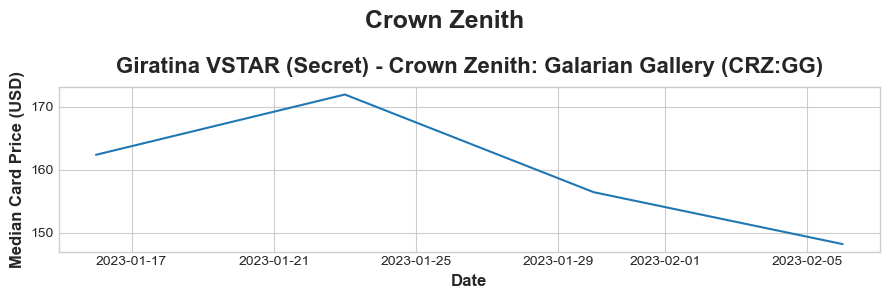

In [33]:
#final results, most recent date:
#will add in loop later
plt.figure(figsize=(9, 3))
plt.title(CardList[0][0])
plt.suptitle(CardList[0][2])
plt.xlabel("Date")
plt.ylabel("Median Card Price (USD)")
plt.plot(dates,marketPrice)